In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import utils as u

In [2]:
EQ_CENTS = np.array([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200])
JI_CENTS = np.array([0, 90, 112, 182, 204, 294, 316, 386, 408, 498, 520, 590, 612, 702, 792, 814, 884, 906, 996, 1018, 1088, 1110, 1200])
notes_dict = {
"Sa": 0,
"Ri": 100,
"Ga": 300,
"Ma": 500,
"Pa": 700,
"Dha": 800,
"Ni": 1000,
"Sa": 1200,
"Ri": 1300,
"Ga": 1500,
}
sr = 16000

In [3]:
# Load processed pitch data
pitchfile = "thodi/Karuna Nidhi Illalo/Karuna Nidhi Illalo.multitrack-violin-alaapana-processed.pitch"
times, f0 = np.loadtxt(pitchfile).T
length_s = times[-1]

# Load the tonics
tonic_violin = np.loadtxt("thodi/Karuna Nidhi Illalo/Karuna Nidhi Illalo.multitrack-violin-main.tonic")
tonic_vocal = np.loadtxt("thodi/Karuna Nidhi Illalo/Karuna Nidhi Illalo.ctonic.txt")
print("Violin tonic:", tonic_violin, "Hz, Vocal tonic:", tonic_vocal, "Hz")

Violin tonic: 135.63082885742188 Hz, Vocal tonic: 135.425885 Hz


In [4]:
# Cents calculation
cents_vi = u.hz_to_cents(f0, tonic_violin)
cents_vi = u.wrap_to_octave(cents_vi)

#### Histogram

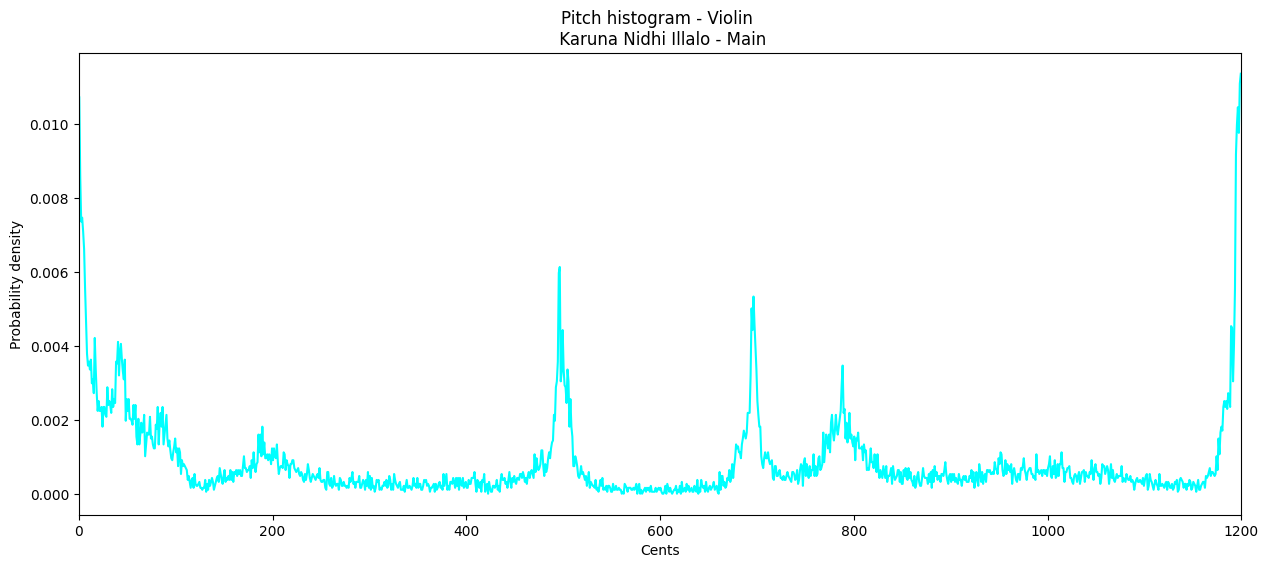

In [5]:
# Plot histogram
bins = np.linspace(0, 1200, 1201)
hist, bin_edges = np.histogram(cents_vi, bins = bins)
hist = hist/np.sum(hist)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2    

plt.figure(figsize=(15, 6))
plt.plot(bin_centers, hist, color = "cyan")
plt.xlabel("Cents")
plt.ylabel("Probability density")
plt.xlim(0, 1200)
plt.title("Pitch histogram - Violin \n Karuna Nidhi Illalo - Main")
plt.show()       


#### KDE

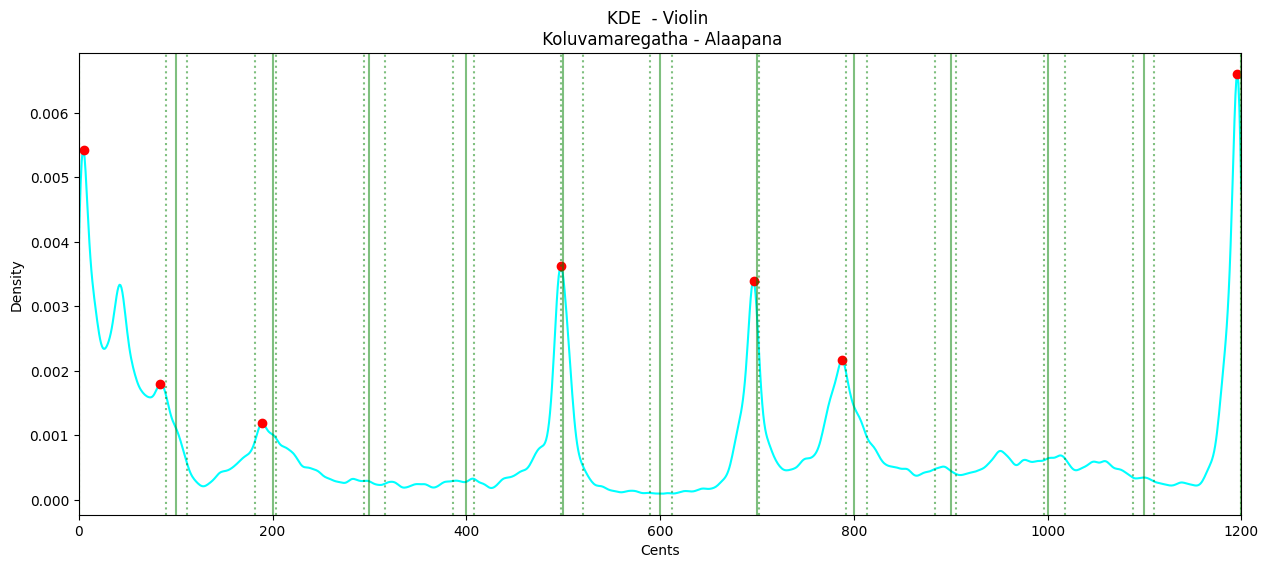

In [6]:
# KDE calculation
kde = u.gaussian_kde(cents_vi[~np.isnan(cents_vi)], bw_method = 0.01)
bins = np.linspace(0, 1200, 1200)
kde_vals = kde(bins)

# Find peaks in KDE
peaks,_ = u.find_peaks(kde_vals, distance = 50, height = 0.0008)

# Plot KDE and peaks
plt.figure(figsize=(15, 6))
plt.plot(bins, kde_vals, color = "cyan")
plt.plot(bins[peaks], kde_vals[peaks], 'ro')
for pos in JI_CENTS:
    plt.axvline(x = pos, color = 'g', linestyle = ':', alpha = 0.5)
for pos in EQ_CENTS:
    plt.axvline(x = pos, color = 'g', linestyle = '-', alpha = 0.5)
plt.xlabel("Cents")
plt.ylabel("Density")
plt.xlim(0, 1200)
plt.title("KDE  - Violin \n Koluvamaregatha - Alaapana")
plt.show()


#### PEAK FITTING

Error fitting peak at index 84: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.


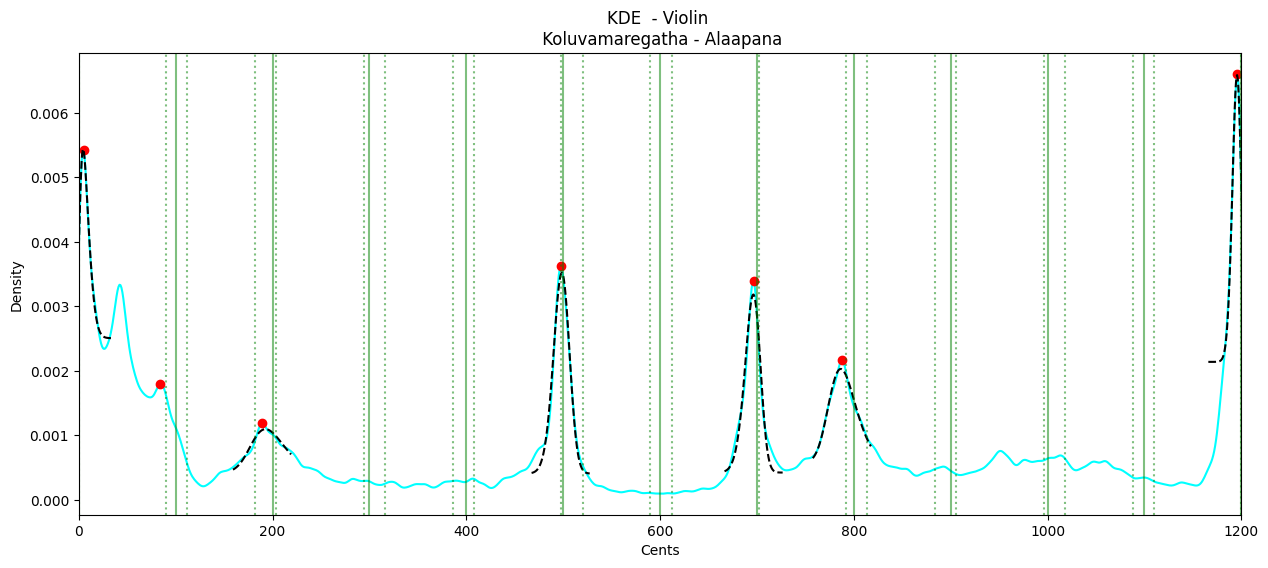

In [12]:
# Find peak parameters
peak_dict = u.fit_histogram(peaks, kde_vals, bins)

# Plot KDE and fitted peaks
plt.figure(figsize=(15, 6))
plt.plot(bins, kde_vals, color = "cyan")
plt.plot(bins[peaks], kde_vals[peaks], 'ro')
for peak, params in peak_dict.items():
    start = peak - 30
    end = peak + 30
    x_vals = np.linspace(start, end, 100)
    y_vals = u.gaussian(x_vals, *params)
    plt.plot(x_vals, y_vals, linestyle = '--', color = 'k')

for pos in JI_CENTS:
    plt.axvline(x = pos, color = 'g', linestyle = ':', alpha = 0.5)
for pos in EQ_CENTS:
    plt.axvline(x = pos, color = 'g', linestyle = '-', alpha = 0.5)
plt.xlabel("Cents")
plt.ylabel("Density")
plt.xlim(0, 1200)
plt.title("KDE  - Violin \n Koluvamaregatha - Alaapana")
plt.show()


In [19]:
# For each peak, find the closest JI and EQ pitch
ji_pitch = []
eq_pitch = []
ji_diff = []
eq_diff = []
for peak in peaks:
    peak_pos = int(bins[peak])
    ji = JI_CENTS[np.argmin(np.abs(JI_CENTS - peak_pos))]
    eq = EQ_CENTS[np.argmin(np.abs(EQ_CENTS - peak_pos))]
    ji_pitch.append(ji)
    eq_pitch.append(eq)
    ji_diff.append(np.abs(peak_pos - ji))
    eq_diff.append(np.abs(peak_pos - eq))

import pandas as pd
df = pd.DataFrame(list(zip(bins[peaks].astype(int), ji_pitch, ji_diff, eq_pitch, eq_diff)), columns = ["Peak", "JI", "JI_diff", "EQ", "EQ_diff"])
display(df)

,Peak,JI,JI_diff,EQ,EQ_diff
0,5,0,5,0,5
1,84,90,6,100,16
2,189,182,7,200,11
3,497,498,1,500,3
4,696,702,6,700,4
5,787,792,5,800,13
6,1195,1200,5,1200,5


In [25]:
mean_pos = [int(key) for key in peak_dict.keys()]
amplitudes = [value[0] for value in peak_dict.values()]
stds = [value[2] for value in peak_dict.values()]
offsets = [value[3] for value in peak_dict.values()]
skewness = [value[4] for value in peak_dict.values()]

amplitudes = amplitudes/np.sum(amplitudes)
offsets = offsets/np.sum(offsets)

In [26]:
pd.options.display.float_format = '{:.2f}'.format
df = pd.DataFrame(list(zip(mean_pos, amplitudes, stds, offsets, skewness)), columns = ["Mean (cents)", "Amplitude (normalized)", "Standard Deviation (cents)", "Offset (normalized)", "Skewness"])
display(df)

,Mean (cents),Amplitude (normalized),Standard Deviation (cents),Offset (normalized),Skewness
0,5,0.16,7.85,0.39,2.98
1,189,0.04,26.64,0.07,2.06
2,497,0.22,10.42,0.06,-1.14
3,696,0.18,10.92,0.07,-1.52
4,787,0.09,21.08,0.09,1.89
5,1195,0.32,5.81,0.33,-1.07


In [28]:
# Save df to a file
csvfile = pitchfile.replace("processed.pitch", "peaks.csv")
df.to_csv("thodi/Karuna Nidhi Illalo/Karuna Nidhi Illalo.multitrack-violin-main-peaks.csv", index = False)